In [24]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from torch.utils.tensorboard import SummaryWriter


N_CLASSES = 91
FINAL_GRID_SIZE = 9
N_ANCHORS = 1
LAST_KERNEL_DIM = N_CLASSES+N_ANCHORS*5
SCALED_IMG_WIDTH = 288
SCALED_IMG_HEIGHT = 288

path2data="./COCO/imgs/train2017"
path2json="./COCO/jsons/annotations/instances_train2017.json"
writer = SummaryWriter('tb/yolo_with_backbone')

device = th.device('cuda' if th.cuda.is_available() else 'cpu')

In [25]:
transform = transforms.Compose([
        transforms.Resize((SCALED_IMG_HEIGHT, SCALED_IMG_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform2view = transforms.Compose([
    transforms.Resize((SCALED_IMG_HEIGHT, SCALED_IMG_WIDTH)),
    transforms.ColorJitter(),
    transforms.RandomGrayscale(p=0.15),
    transforms.ToTensor(),
    transforms.RandomErasing(scale=(0.02, 0.10), value='random'),
    transforms.ToPILImage()
])
transform_augmentation = transforms.Compose([
    transforms.RandomGrayscale(p=0.15),
    transform,
    transforms.ColorJitter(),
    transforms.RandomErasing(scale=(0.02, 0.10), value='random')
])

In [26]:
def save(name, major, minor):
    YOLO_PATH = 'pretrained_models/yolo' +name+'_'+str(major)+'_'+str(minor)+'.th'
    OPT_PATH  = 'pretrained_models/opt' +name+'_'+str(major)+'_'+str(minor)+'.th'
    torch.save(yolo.state_dict(), YOLO_PATH)
    torch.save(opt.state_dict(),   OPT_PATH+name+'_'+str(major)+'_'+str(minor)+'.th')
def load(name, major, minor):
    YOLO_PATH = 'pretrained_models/yolo' +name+'_'+str(major)+'_'+str(minor)+'.th'
    OPT_PATH  = 'pretrained_models/opt' +name+'_'+str(major)+'_'+str(minor)+'.th'
    yolo.load_state_dict(torch.load(YOLO_PATH))
    # yolo.eval()
    opt.load_state_dict(torch.load(OPT_PATH))

In [27]:
def draw_bounding_box(
    tensor,
    bboxes,
    strings,
    color=None,
    width=1,
    font_size=None
):

    from PIL import Image, ImageDraw, ImageFont
    ndarr = tensor.mul(255).add_(0.5).clamp_(0, 255).permute(
        1, 2, 0).to('cpu', torch.uint8).numpy()
    im = Image.fromarray(ndarr)
    draw = ImageDraw.Draw(im)
    img_h = tensor.shape[1]
    if font_size is None:
        print(tensor.shape)
        font_size = int(25/600*img_h)
    font = ImageFont.truetype("font.otf", font_size)

    if color is None:
        all_colors = [(i*255, j*255, k*255) for i in range(2) for j in range(2) for k in range(2)]
        colors = random.choices(all_colors, k=len(bboxes))
    elif len(color) == 3 and isinstance(color[0], int):
        colors = [color]*len(bboxes)
    else:
        colors = color

    for bbox, color, string in zip(bboxes, colors, strings):
        textbox_width = int(font_size*len(string)*20/25)
        textbox_height = font_size+3
        y2 = bbox[1]-textbox_height
        if y2 < 0:
            y2 = bbox[1]+textbox_height
        fillbbox = [bbox[0], bbox[1], bbox[0]+textbox_width, y2]
        textbox = (bbox[0], min(bbox[1], y2))
        textcolor = tuple(255-c for c in color)  

        draw.rectangle(bbox, outline=color, width=width)
        draw.rectangle(fillbbox, fill=color, width=width)
        draw.text(textbox, string, fill=textcolor, font=font)

    from numpy import array as to_numpy_array
    return torch.from_numpy(to_numpy_array(im))

def visualize_img(img, annotation, color=None, width=3):
    img = transforms.ToTensor()(img)
    bboxes = []
    strings = []
    for ann in annotation:
        ann2 = ann['bbox']
        ann2 = ann2[0], ann2[1], ann2[0]+ann2[2], ann2[1]+ann2[3]
        bboxes.append(ann2)
        strings.append(cats[ann['category_id']])
        # print(strings[-1], ann['category_id'], type(cats[ann['category_id']]), cats[ann['category_id']])


    img = draw_bounding_box(img, bboxes, strings, color=None, width=width)
    plt.imshow(img.numpy())


In [28]:
def transform_f (img, annotations, train=True, size=(SCALED_IMG_HEIGHT, SCALED_IMG_WIDTH)):
    if train:
        transform = transform_augmentation
    else:
        transform = transform2view
    w, h = img.size[1], img.size[0]
    scalex = size[1]/w
    scaley = size[0]/h
    if scalex == 1:
        print("eq")
    import copy 
    annotations = copy.deepcopy(annotations)
    for i, ann in enumerate(annotations):
        a = ann['bbox']
        a = (a[0]*scaley, a[1]*scalex, a[2]*scaley, a[3]*scalex)
        annotations[i]['bbox'] = a
    img = transform(img)
    return img, annotations

In [6]:
def batching_func(l):
    import math
    imgs = [x[0].unsqueeze(0) for x in l]
    imgs = torch.cat(imgs, dim=0)
    w, h = imgs.shape[-2], imgs.shape[-1]
    idiv = h/FINAL_GRID_SIZE
    jdiv = w/FINAL_GRID_SIZE
    target = torch.zeros(len(imgs), LAST_KERNEL_DIM, FINAL_GRID_SIZE, FINAL_GRID_SIZE)
    class_ids     = torch.zeros(len(imgs), N_CLASSES,   FINAL_GRID_SIZE, FINAL_GRID_SIZE)
    objectness    = torch.zeros(len(imgs), N_ANCHORS,   FINAL_GRID_SIZE, FINAL_GRID_SIZE)
    offsets       = torch.zeros(len(imgs), N_ANCHORS*2, FINAL_GRID_SIZE, FINAL_GRID_SIZE)
    normalized_wh = torch.zeros(len(imgs), N_ANCHORS*2, FINAL_GRID_SIZE, FINAL_GRID_SIZE)
    lasti = 0

    annotations = [x[1] for x in l]
    for el, annotation in enumerate(annotations):
        for ann in annotation:
            bbox = ann['bbox']
            class_id = ann['category_id']
            celli = (bbox[0]+bbox[2])/2/idiv
            cellj = (bbox[1]+bbox[3])/2/jdiv
            i = int(celli)
            j = int(cellj)
            offset_i = celli - i
            offset_j = cellj - j
            normalized_w = math.sqrt(bbox[2]/w)
            normalized_h = math.sqrt(bbox[3]/h)

            class_ids[el, class_id, i, j] = 1
            objectness[el, lasti, i, j] = 1
            offsets[el, lasti*2:(lasti+1)*2, i, j] = torch.tensor([offset_i, offset_j], dtype=torch.float)
            normalized_wh[el, lasti*2:(lasti+1)*2, i, j] = torch.tensor([normalized_w, normalized_h], dtype=torch.float)
            lasti = (lasti+1)%N_ANCHORS
            # print(celli, cellj)
    return imgs, (class_ids, objectness, offsets, normalized_wh)

In [7]:
coco_train = dset.CocoDetection(root = path2data,
                                annFile = path2json,
                                transforms=transform_f)

cats = coco_train.coco.loadCats(coco_train.coco.getCatIds())
cats2 = []
for cat in cats:
    while cat['id'] != len(cats2):
        cats2.append('None')
    cats2.append(cat['name'])
cats = cats2

loading annotations into memory...
Done (t=17.50s)
creating index...
index created!


torch.Size([3, 480, 640])


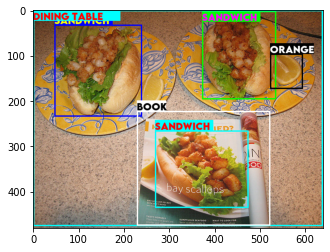

In [29]:
import random
import torch
ii = random.randint(0, 10000)
coco_train.transforms = None
img, ann = coco_train[ii]
coco_train.transforms = transform_f
visualize_img(img, ann)

In [30]:
batching_f

NameError: name 'batching_f' is not defined

torch.Size([3, 288, 288])


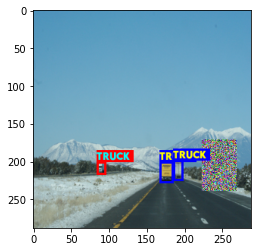

In [13]:
ten, ann = transform_f(img, ann)
img = transform2view(img)
visualize_img(img, ann)

In [32]:
data_loader = torch.utils.data.DataLoader(coco_train,
                                          batch_size=10,
                                          shuffle=True,
                                          num_workers=1,
                                          collate_fn=batching_func
                                        )

In [34]:
for batch in data_loader:
    data = batch
    break

data[-1][-1]

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.2610, 0.3417,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.1862, 0.3011,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.3936, 0.5807,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.3604, 0.4551,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.1734,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

In [31]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.zero_pad = nn.ZeroPad2d(1)
        self.conv = nn.Conv2d(kernel_size=3, in_channels=in_channels, out_channels=out_channels, stride=stride)
        self.bnorm = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        x = self.zero_pad(x)
        x = self.conv(x)
        x = self.bnorm(x)
        x = F.relu(x)
        return x

class Yolo(nn.Module):
    def __init__(self, conv_list, nc_last_conv, device):
        super().__init__()
        self.conv_list = conv_list
        self.conv_layers = []
        self.last_conv = nn.Conv2d(kernel_size=1, in_channels=conv_list[-1][0], out_channels=nc_last_conv, stride=1)
        for (in_channels, _), (out_channels, stride) in zip(conv_list[:-1], conv_list[1:]):
            self.conv_layers.append(ConvLayer(in_channels, out_channels, stride).to(device))
        self.default_anchor_size = 0.3

    def forward(self, x, separate=True):
        for layer, (inc, _), (outc, stride) in zip(self.conv_layers, conv_list[:-1], conv_list[1:]):
            skip = x
            x = layer(x)
            # print(x.shape)
            if inc==outc and stride==1:
                x += skip
        
        # print(x.shape)
        x = self.last_conv(x)
        # print(x.shape)

        class_preds = x[:, :91,   :, :]
        objectness  = x[:, 91,    :, :].unsqueeze(1)
        offsets     = x[:, 92:94, :, :]
        boxes       = x[:, 94:96,   :, :]

        objectness  = th.sigmoid(objectness)
        boxes       = th.exp(boxes) * self.default_anchor_size
        offsets     = th.sigmoid(offsets) 
        class_preds = th.sigmoid(class_preds)
        # print("-"*10)
        if separate:
            return class_preds, objectness, offsets, boxes
        return torch.cat((class_preds, objectness, offsets, boxes), dim=1)

class Detector(nn.Module):
    def __init__(self, conv_list, device):
        super().__init__()
        self.backbone = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True).features.to(device)
        self.backbone.eval()
        for p in self.backbone:
            p.requires_grad = False
        self.head = Yolo(conv_list, LAST_KERNEL_DIM, device=device).to(device)
    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)

# out_channels, stride
conv_list = [
    [3, 1], #dummy begin
    [32, 2],
    [32, 1],
    [64, 2],
    [64, 1],
    [64, 1],
    [128, 2],
    [128, 1],
    [128, 1],
    [512, 2],
    [512, 1],
    [512, 1],
    [1024, 2],
    [1024, 1],
    [1024, 1],
]
conv_list_mobile = [
    [1280, 1], #dummy begin
    [1024, 1],
    [1024, 1]
]

try:
    del yolo
except:
    pass
# yolo = Yolo(conv_list, LAST_KERNEL_DIM, device=device).to(device)
yolo = Detector(conv_list_mobile, device)

Using cache found in /home/darijan/.cache/torch/hub/pytorch_vision_v0.6.0


In [36]:
opt = th.optim.Adam([
    # {'params':yolo.backbone.parameters(), 'lr':1e-4},
    {'params':yolo.head.parameters()}
])

In [14]:
def bce(targets, preds, lmbda, indicator=None, numsc = 1e-8):
    t1 =  -(lmbda*targets*th.log(preds+numsc) + (1-targets)*th.log(1-preds+numsc))
    if indicator is None:
        return t1.mean()
    # print(t1.shape, indicator.shape, (t1*indicator).shape)
    return (t1*indicator).sum()/indicator.sum()

eps = 10
numsc = 1e-9
i_mbatch = 16030
for ep in range(eps):
    for i_mbatch2, (imgs, targets) in enumerate(data_loader):
        i_mbatch += 1
        class_ids, objectness, offsets, normalized_wh = targets
        class_ids, objectness, offsets, normalized_wh = class_ids.to(device), objectness.to(device), offsets.to(device), normalized_wh.to(device)
        preds_class_ids, preds_objectness, preds_offsets, preds_normalized_wh = yolo(imgs.to(device))
        
        indicator = class_ids.sum(dim=1).unsqueeze(1) > 0.5
        loss_c   = bce(class_ids, preds_class_ids, 1, indicator)
        loss_obj = bce(objectness, preds_objectness, 20)/20
        loss_off = bce(offsets, preds_offsets, 1, indicator)
        loss_wh  = (((normalized_wh-preds_normalized_wh)**2) *indicator).sum()/indicator.sum()
        
        loss = loss_c*10 + loss_obj + loss_off + loss_wh*10
        opt.zero_grad()
        loss.backward()
        opt.step()

        if i_mbatch%100==0:
            print(ep, i_mbatch, loss_c.item(), loss_obj.item(), loss_off.item(), loss_wh.item())
        if i_mbatch % 750==0:
            save('with_backbone_', ep, i_mbatch)

        step = ep*15000 + i_mbatch
        writer.add_scalar('loss/class', loss_c, step)
        writer.add_scalar('loss/object', loss_obj, step)
        writer.add_scalar('loss/offset', loss_off, step)
        writer.add_scalar('loss/bbox_wh', loss_wh, step)



torch.Size([10, 91, 9, 9]) torch.Size([10, 1, 9, 9]) torch.Size([10, 91, 9, 9])
torch.Size([10, 2, 9, 9]) torch.Size([10, 1, 9, 9]) torch.Size([10, 2, 9, 9])
torch.Size([10, 91, 9, 9]) torch.Size([10, 1, 9, 9]) torch.Size([10, 91, 9, 9])
torch.Size([10, 2, 9, 9]) torch.Size([10, 1, 9, 9]) torch.Size([10, 2, 9, 9])
torch.Size([10, 91, 9, 9]) torch.Size([10, 1, 9, 9]) torch.Size([10, 91, 9, 9])
torch.Size([10, 2, 9, 9]) torch.Size([10, 1, 9, 9]) torch.Size([10, 2, 9, 9])
torch.Size([10, 91, 9, 9]) torch.Size([10, 1, 9, 9]) torch.Size([10, 91, 9, 9])
torch.Size([10, 2, 9, 9]) torch.Size([10, 1, 9, 9]) torch.Size([10, 2, 9, 9])
torch.Size([10, 91, 9, 9]) torch.Size([10, 1, 9, 9]) torch.Size([10, 91, 9, 9])
torch.Size([10, 2, 9, 9]) torch.Size([10, 1, 9, 9]) torch.Size([10, 2, 9, 9])
torch.Size([10, 91, 9, 9]) torch.Size([10, 1, 9, 9]) torch.Size([10, 91, 9, 9])
torch.Size([10, 2, 9, 9]) torch.Size([10, 1, 9, 9]) torch.Size([10, 2, 9, 9])


KeyboardInterrupt: 

In [17]:
a = torch.tensor([1, 2, 3, 4])
a **2* a

tensor([ 1,  8, 27, 64])

In [37]:
load('with_backbone_', 0, 0)
# del yolo

In [15]:
del class_ids, objectness, offsets, normalized_wh
del preds_class_ids, preds_objectness, preds_offsets, preds_normalized_wh

torch.Size([3, 470, 500])


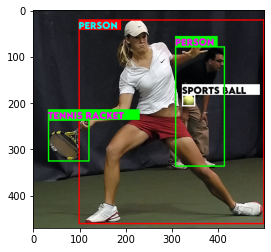

In [38]:
import random
import torch
ii = random.randint(0, 10000)
coco_train.transforms = None
img, ann = coco_train[ii]
coco_train.transforms = transform_f
visualize_img(img, ann)

torch.Size([1, 1, 9, 9]) 1
<class 'PIL.Image.Image'> <class 'list'>
torch.Size([3, 288, 288])


4

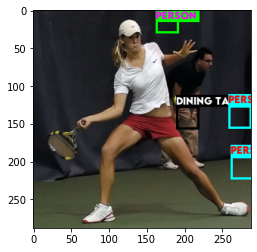

In [41]:
tens, ann = transform_f(img, ann)
imgs, _ = batching_func([[tens, ann]])
yolo.eval()
preds_class_ids, preds_objectness, preds_offsets, preds_normalized_wh = yolo(imgs.to(device))
yolo.train()

print(preds_objectness.shape, len(imgs))
objectness = preds_objectness.squeeze(0).squeeze(0)
class_id   = th.argmax(preds_class_ids, dim=1).squeeze(0)
class_prob = th.max(preds_class_ids, dim=1)[0].squeeze(0)
prob = objectness*class_prob   
prob = objectness     
# class_ids, objectness, offsets, normalized_wh = class_ids.to(device), objectness.to(device), offsets.to(device), normalized_wh.to(device)

yolo_ann = []
thres = 0.6
annotations = []
for i in range(FINAL_GRID_SIZE):
    for j in range(FINAL_GRID_SIZE):
        if prob[i, j].item() > thres:
            centy = (i+preds_offsets[0, 0, i, j]).item()*SCALED_IMG_HEIGHT/FINAL_GRID_SIZE
            centx = (j+preds_offsets[0, 1, i, j]).item()*SCALED_IMG_WIDTH /FINAL_GRID_SIZE
            width = th.square(preds_normalized_wh[0, 0, i, j]).item() * SCALED_IMG_WIDTH
            height= th.square(preds_normalized_wh[0, 1, i, j]).item() * SCALED_IMG_HEIGHT
            width = height = 30
            top_left_x = centx-width/2
            top_left_y = centy-height/2
            bbox = [top_left_x, top_left_y, width, height]
            category_id = int(class_id[i, j].item())
            ann_tmp = {'bbox':bbox, 'category_id':category_id}
            # dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])
            annotations.append(ann_tmp)
            


            
            
offsets    = preds_offsets.squeeze(0)
# del preds_class_ids, preds_objectness, preds_offsets, preds_normalized_wh
small_img = transforms.Resize((SCALED_IMG_WIDTH, SCALED_IMG_WIDTH))(img)
print(type(small_img), type(annotations))
visualize_img(small_img, annotations)
len(annotations)

In [42]:
preds_normalized_wh[0, 0]

tensor([[3.2690e-08, 1.0469e-08, 1.8601e-09, 1.8648e-10, 2.6022e-11, 2.6064e-11,
         9.8032e-11, 3.6905e-10, 2.9048e-09],
        [2.6017e-08, 8.7111e-09, 1.0819e-09, 1.4847e-11, 2.5882e-13, 1.4451e-13,
         1.4770e-12, 1.2851e-11, 3.2239e-10],
        [2.4630e-08, 3.1250e-09, 3.7642e-10, 1.3809e-12, 6.1302e-14, 7.8968e-15,
         7.7046e-14, 6.9044e-12, 3.3728e-10],
        [4.2601e-09, 1.4807e-10, 1.5600e-11, 3.1794e-13, 1.1908e-13, 2.6178e-14,
         3.0356e-14, 4.8721e-12, 2.3834e-10],
        [4.5337e-10, 1.2090e-11, 2.1009e-12, 2.8657e-13, 3.8709e-13, 3.0480e-13,
         3.7295e-13, 3.4697e-11, 7.7207e-10],
        [1.9593e-10, 1.1305e-11, 6.7222e-12, 1.4615e-12, 1.7959e-12, 7.7347e-12,
         9.8005e-12, 8.3411e-11, 7.1044e-10],
        [9.2521e-10, 1.0078e-10, 5.5532e-11, 1.7081e-11, 2.8648e-11, 8.9080e-11,
         2.3515e-11, 4.6215e-12, 3.1671e-11],
        [3.4527e-09, 4.7925e-10, 5.4649e-10, 5.2071e-10, 5.5293e-10, 2.1009e-10,
         6.3046e-12, 2.0722e-1

tensor([[ 1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1, 70,  1,  1],
        [ 1,  1,  1,  1,  1, 70,  1,  1,  1],
        [ 1,  1,  1,  1, 81, 43,  1,  1,  1],
        [ 1,  1,  1, 67,  1, 84, 62,  1,  1],
        [ 1,  1,  1, 67,  1, 84,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1]], device='cuda:0')

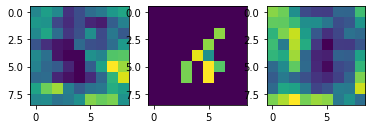

In [40]:
plt.subplot(1, 3, 1)
plt.imshow(objectness.cpu().detach().numpy())
plt.subplot(1, 3, 2)
plt.imshow(class_id.cpu().detach().numpy())
plt.subplot(1, 3, 3)
plt.imshow(class_prob.cpu().detach().numpy())
class_id

In [75]:
del yolo
del class_ids, objectness, offsets, normalized_wh
del preds_class_ids, preds_objectness, preds_offsets, preds_normalized_wh

NameError: name 'preds_class_ids' is not defined

In [20]:
objectness

tensor([[0.3509, 0.4248, 0.3576, 0.5285, 0.5406, 0.5945, 0.1866, 0.2041, 0.0768],
        [0.2134, 0.4749, 0.6163, 0.8566, 0.6811, 0.6789, 0.4635, 0.4169, 0.1394],
        [0.3068, 0.4433, 0.2448, 0.6362, 0.5793, 0.4547, 0.0816, 0.2810, 0.0739],
        [0.4224, 0.5406, 0.1429, 0.4288, 0.2819, 0.2687, 0.0680, 0.1142, 0.0551],
        [0.2768, 0.4906, 0.3896, 0.5171, 0.6822, 0.6659, 0.2674, 0.0853, 0.0324],
        [0.3369, 0.5111, 0.6145, 0.3305, 0.5632, 0.4513, 0.1424, 0.1214, 0.0590],
        [0.1698, 0.2449, 0.4685, 0.1806, 0.3750, 0.6763, 0.4605, 0.1151, 0.0432],
        [0.1103, 0.0945, 0.0506, 0.1203, 0.1469, 0.0526, 0.1279, 0.0700, 0.0548],
        [0.0288, 0.0353, 0.0486, 0.0327, 0.0166, 0.0148, 0.0285, 0.0118, 0.0231]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)